In [1]:
#Import
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize

In [2]:
# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_json('../Data/V10/dblp-ref/dblp-ref-0.json', lines=True)

In [4]:
df_copy = df.copy()


In [5]:
def calculate_page_rank_utility(df_pageRank):
    from  itertools import chain
    df_pageRank_flatten = pd.DataFrame({
            "abstract": np.repeat(df_pageRank.abstract.values, df_pageRank.references.str.len()),
            "authors": np.repeat(df_pageRank.authors.values, df_pageRank.references.str.len()),
            "id": np.repeat(df_pageRank.id.values, df_pageRank.references.str.len()),
            "n_citation": np.repeat(df_pageRank.n_citation.values, df_pageRank.references.str.len()),
            "references": list(chain.from_iterable(df_pageRank.references)),
            "title": np.repeat(df_pageRank.title.values, df_pageRank.references.str.len()),
            "venue": np.repeat(df_pageRank.venue.values, df_pageRank.references.str.len()),
            "year": np.repeat(df_pageRank.year.values, df_pageRank.references.str.len()),        
            "pageRankValue": np.repeat(df_pageRank.pageRankValue.values, df_pageRank.references.str.len()),
            "totalOutbounds": np.repeat(df_pageRank.totalOutbounds.values, df_pageRank.references.str.len()),
            "ratio": np.repeat(df_pageRank.ratio.values, df_pageRank.references.str.len())        
    })

    df_pageRank_flatten_groupby = df_pageRank_flatten.groupby('references').agg({'ratio' : 'sum'})
    df_pageRank_flatten_groupby['id'] = df_pageRank_flatten_groupby.index
    df_pageRank_flatten_groupby['newPageRankValue'] = df_pageRank_flatten_groupby['ratio']

    df_pageRank_new = pd.merge(df_pageRank, df_pageRank_flatten_groupby[['id', 'newPageRankValue']], how='left', on='id')
    df_pageRank_new.pageRankValue = df_pageRank_new.newPageRankValue
    df_pageRank_new['ratio'] = df_pageRank_new.pageRankValue / df_pageRank_new.totalOutbounds
    df_pageRank_new = df_pageRank_new.drop(columns = ['newPageRankValue'])

    return df_pageRank_new

def calculate_page_rank (df, iteration):
    for i in range (0, iteration):
        df = calculate_page_rank_utility(df)
    return df

In [6]:
df_page_rank_actual = df.copy()

In [7]:
df_page_rank_actual.shape

(1000000, 8)

In [8]:
#placing [self] where references is nan
df_page_rank_actual.loc[df_page_rank_actual['references'].isnull(),['references']] = df_page_rank_actual.loc[df_page_rank_actual['references'].isnull(),'references'].apply(lambda references : ['self'])

#also do for empty array
df_page_rank_actual.references = df_page_rank_actual.references.apply(lambda y: ['self'] if len(y)==0 else y)

#without [self], empty array, on flatten entries with empty array will be deleted

In [9]:
from  itertools import chain
df_page_rank_actual_flatten_references = pd.DataFrame({
            "id": np.repeat(df_page_rank_actual.id.values, df_page_rank_actual.references.str.len()),
            "references": list(chain.from_iterable(df_page_rank_actual.references))
    })

In [10]:
unique_paper_id = df_page_rank_actual_flatten_references.id.unique()

unique_reference_id = df_page_rank_actual_flatten_references.references.unique()

print (unique_paper_id.shape)

print (unique_reference_id.shape)

diff_set = set(unique_reference_id)-set(unique_paper_id)
#print (diff_set)
print (len(diff_set))

(1000000,)
(1291817,)
854174


In [11]:
df_page_rank_actual_flatten_references = df_page_rank_actual_flatten_references[~df_page_rank_actual_flatten_references['references'].isin(diff_set)]


In [12]:
df_page_rank_actual_flatten_references = df_page_rank_actual_flatten_references.groupby('id').agg({'references':lambda x: list(x)})


In [13]:
df_page_rank_actual_flatten_references['id'] = df_page_rank_actual_flatten_references.index

df_page_rank_actual_flatten_references['references2'] = df_page_rank_actual_flatten_references['references']

In [14]:
df_page_rank_actual = pd.merge(df_page_rank_actual, df_page_rank_actual_flatten_references[['id', 'references2']], how='left', on='id')


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
df_page_rank_actual['references'] = df_page_rank_actual['references2']

df_page_rank_actual = df_page_rank_actual.drop(columns = ['references2'])

In [16]:
#add 3 columns required for calculating page rank

df_page_rank_actual['pageRankValue'] = 100
df_page_rank_actual['totalOutbounds'] = df_page_rank_actual.references.str.len()
df_page_rank_actual['ratio'] = df_page_rank_actual.pageRankValue / df_page_rank_actual.totalOutbounds


In [17]:
df_page_rank_actual.shape

(1000000, 11)

In [18]:
df_page_rank_actual['pageRankValue'].sum()

100000000

In [19]:
#df_page_rank_actual_iterate1 = calculate_page_rank(df_page_rank_actual, 1)

#error because of NaN in references data .... after left join .... some rows were not found

In [20]:
#placing [self] where references is nan
df_page_rank_actual.loc[df_page_rank_actual['references'].isnull(),['references']] = df_page_rank_actual.loc[df_page_rank_actual['references'].isnull(),'references'].apply(lambda references : ['self'])

#also do for empty array
df_page_rank_actual.references = df_page_rank_actual.references.apply(lambda y: ['self'] if len(y)==0 else y)

#without [self], empty array, on flatten entries with empty array will be deleted

In [21]:
df_page_rank_actual_iterate1 = calculate_page_rank(df_page_rank_actual, 1)

In [22]:
df_page_rank_actual_iterate1['pageRankValue'].sum()

62949600.00000001

In [23]:
#df_page_rank_actual_iterate1.query('id == \'086c091e-d905-4f1c-9385-eec41ad55723\'')
df_page_rank_actual_iterate2 = calculate_page_rank(df_page_rank_actual_iterate1, 1)


In [24]:
df_page_rank_actual_iterate2['pageRankValue'].sum()

44888464.56189278

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


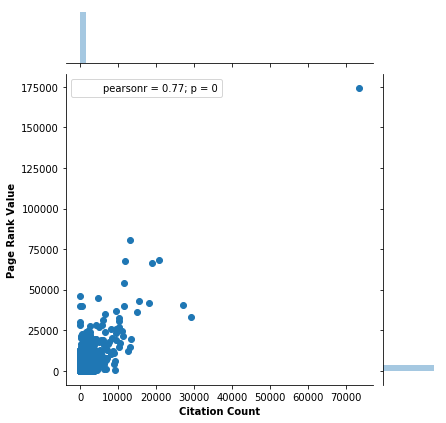

In [26]:
#graph for correlation between pageRank and citation count

g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate2)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')

In [ ]:
#citation count vs pageRank

"""
g = sns.jointplot(x="pageRankValue", y="n_citation", data=df_page_rank_actual_iterate2)
g.set_axis_labels('Page Rank Value', 'Citation Count', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')
"""

In [27]:
"""
df_page_rank_actual_iterate_graph = df_page_rank_actual_iterate2.copy()
df_page_rank_actual_iterate_graph = df_page_rank_actual_iterate_graph[df_page_rank_actual_iterate_graph.n_citation < 35000]

g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')

g = sns.jointplot(x="pageRankValue", y="n_citation", data=df_page_rank_actual_iterate_graph)
g.set_axis_labels('Page Rank Value', 'Citation Count', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')


"""

'\ndf_page_rank_actual_iterate_graph = df_page_rank_actual_iterate2.copy()\ndf_page_rank_actual_iterate_graph = df_page_rank_actual_iterate_graph[df_page_rank_actual_iterate_graph.n_citation < 35000]\n\ng = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph)\ng.set_axis_labels(\'Citation Count\', \'Page Rank Value\', fontsize=10, fontweight=\'bold\')\n#g.savefig(\'Page_Rank_Vs_Citation_Count_1.png\')\n\ng = sns.jointplot(x="pageRankValue", y="n_citation", data=df_page_rank_actual_iterate_graph)\ng.set_axis_labels(\'Page Rank Value\', \'Citation Count\', fontsize=10, fontweight=\'bold\')\n#g.savefig(\'Page_Rank_Vs_Citation_Count_1.png\')\n\n\n'

In [28]:
#df_page_rank_actual[df_page_rank_actual.references.str.len() == 0].shape

#delete all rows which doesnot have any out-degree, that is they do not refer to any of the papers. 
#Page rank is not defined for those nodes



#delete rows with null or nan in references column



#df_page_rank_actual[df_page_rank_actual['references'].notnull()].shape



#1. flatten by references column
#2. make new dataframe by group by on references (have unique paper id in references column)
#3. take inner join with original dataframe so that both column (id and references) will have same unique entries



#df_page_rank_actual_flatten_references.references.unique().shape
#df_page_rank_actual_flatten_references.drop_duplicates(['references']).shape



#need to remove from references array also
#update n_citation count also ... not consistent with cleaned data


In [48]:
df_page_rank_actual_iterate2 = calculate_page_rank(df_page_rank_actual_iterate1, 1)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


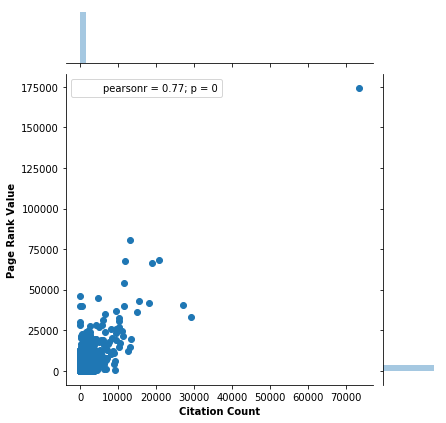

In [49]:
#graph for correlation between pageRank and citation count

g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate2)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')

In [39]:
#df_page_rank_actual_iterate2[~df_page_rank_actual_iterate2['pageRankValue'].notnull()].pageRankValue.unique

print (df_page_rank_actual_iterate2[~df_page_rank_actual_iterate2['pageRankValue'].notnull()].pageRankValue.shape)
print (df_page_rank_actual_iterate2[df_page_rank_actual_iterate2['pageRankValue'].notnull()].pageRankValue.shape)

(562357,)
(437643,)


In [42]:
#df_page_rank_actual_iterate2[~df_page_rank_actual_iterate2['pageRankValue'].notnull()].pageRankValue.unique

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


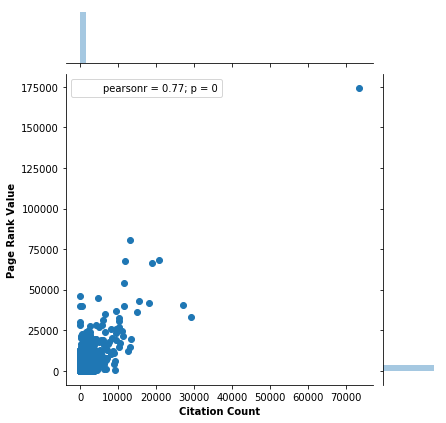

In [50]:
df_page_rank_actual_iterate_graph = df_page_rank_actual_iterate2.copy()
df_page_rank_actual_iterate_graph = df_page_rank_actual_iterate2[df_page_rank_actual_iterate2['pageRankValue'].notnull()]

g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')



In [ ]:
g = sns.jointplot(x="pageRankValue", y="n_citation", data=df_page_rank_actual_iterate_graph)
g.set_axis_labels('Page Rank Value', 'Citation Count', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')

In [53]:
df_page_rank_actual_iterate_graph.sort_values(by=['pageRankValue'], ascending=False).head(5)

,abstract,authors,id,n_citation,references,title,venue,year,pageRankValue,totalOutbounds,ratio
551841,From the Publisher:#R##N#This book brings toge...,[David E. Goldberg],6a6b9aa6-683f-4c7c-b06e-9c3018d10fd3,73362,[self],"Genetic Algorithms in Search, Optimization and...",,1989,174185.241662,NaN,NaN
557560,"From the Publisher:#R##N#With this text, you g...","[Alfred V. Aho, John E. Hopcroft]",a662a4e7-415e-417e-8a8f-fe085d7e487f,13227,[self],The Design and Analysis of Computer Algorithms,,1974,80326.457054,NaN,NaN
676454,NaN,"[Gerard Salton, Michael J. McGill]",e75d8e62-a86d-4241-953f-1b315005d920,20878,[self],Introduction to Modern Information Retrieval,,1986,68402.389585,NaN,NaN
749292,NaN,"[Anil K. Jain, Richard C. Dubes]",1017d9d4-9a4c-423d-ad40-6d9bebbd6b31,11759,[32ba673c-4d72-41a9-8596-272a9009cbb5],Algorithms for clustering data,Technometrics,1988,67491.685051,1.0,67491.685051
953270,An encryption method is presented with the nov...,"[Ronald L. Rivest, Adi Shamir, Leonard M. Adle...",3fb43b00-905c-4a08-934d-198ea4eb66c3,18861,"[011d7883-14a9-438c-98af-df7374058a85, 0d1ade2...",A method for obtaining digital signatures and ...,Communications of The ACM,1978,66109.204465,2.0,33054.602233


In [54]:
df_page_rank_actual_iterate_graph = df_page_rank_actual_iterate_graph[df_page_rank_actual_iterate_graph.pageRankValue > 0]


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


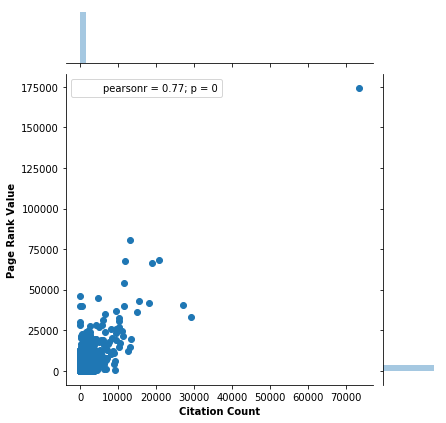

In [55]:
g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_1.png')


In [56]:
df_page_rank_actual_iterate_graph = df_page_rank_actual_iterate_graph[df_page_rank_actual_iterate_graph.pageRankValue < 100000]


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


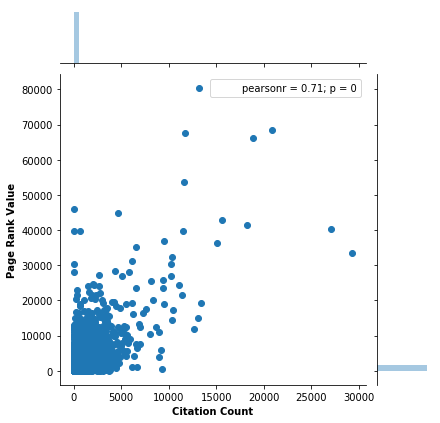

In [58]:
g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
g.savefig('Page_Rank_Vs_Citation_Count_1.png')


In [59]:
df_page_rank_actual_iterate_graph2 = df_page_rank_actual_iterate_graph.copy()
df_page_rank_actual_iterate_graph2 = df_page_rank_actual_iterate_graph2.sample(frac=0.5)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


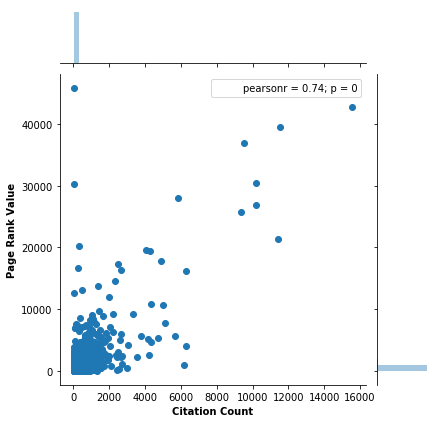

In [70]:
g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph2)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_2.png')


In [61]:
df_page_rank_actual_iterate_graph2 = df_page_rank_actual_iterate_graph2.sample(frac=0.5)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


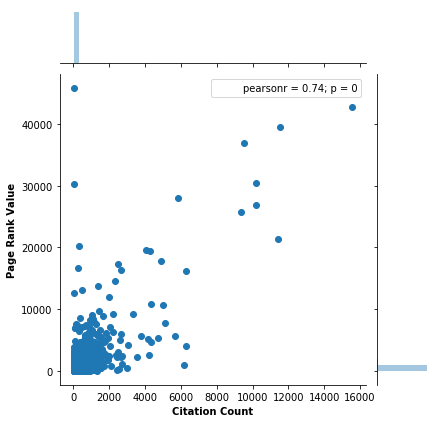

In [71]:
g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph2)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_2.png')


In [63]:
df_page_rank_actual_iterate_graph2.shape

(74539, 11)

In [90]:
df_page_rank_actual_iterate_graph2 = df_page_rank_actual_iterate_graph2.sample(frac=0.5)
df_page_rank_actual_iterate_graph2.shape

(2330, 11)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


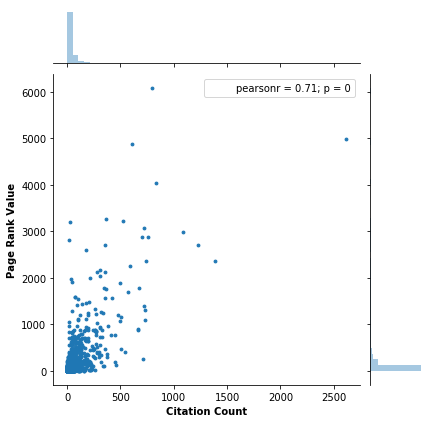

In [91]:
g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph2, s=8)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
#g.savefig('Page_Rank_Vs_Citation_Count_2.png')


In [92]:
df_page_rank_actual_iterate_graph3 = df_page_rank_actual_iterate_graph2[df_page_rank_actual_iterate_graph2.pageRankValue < 2500]


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


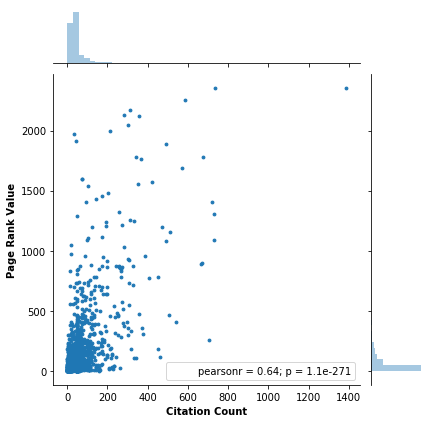

In [93]:
g = sns.jointplot(x="n_citation", y="pageRankValue", data=df_page_rank_actual_iterate_graph3, s=8)
g.set_axis_labels('Citation Count', 'Page Rank Value', fontsize=10, fontweight='bold')
g.savefig('Page_Rank_Vs_Citation_Count_3.png')
